# PCA

In [1]:
# Let's look at the processor we're running
!nvidia-smi

Fri Mar  4 21:38:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 497.29       Driver Version: 497.29       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:23:00.0  On |                  N/A |
| 58%   29C    P0    43W / 215W |    611MiB /  8192MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ... WDDM  | 00000000:2D:00.0  On |                  N/A |
|  0%   

In [2]:
import numpy as np
import tensorflow as tf
from numpy.linalg import norm
import pickle
import random
from tqdm import tqdm, tqdm_notebook
import os
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
%matplotlib inline

import PIL
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D

In [3]:
# Setup tensorflow GPUs
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
gpu_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
# Helper function to get features
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path, target_size=(
        input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

# Extract features
def get_file_list(root_dir):
    extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list

# Helper function to get the classname
def classname(str):
    return str.split('\\')[-2]

# Helper function that calculates accuracy using the nearest neighbors brute force algorithm
def calculate_accuracy(feature_list):
    num_nearest_neighbors = 5
    correct_prediction = 0
    incorrect_prediction = 0
    neighbors = NearestNeighbors(n_neighbors=num_nearest_neighbors,
                                 algorithm='brute',
                                 metric='euclidean').fit(feature_list)
    start = time.time()
    for i in range(len(feature_list)):
        distances, indices = neighbors.kneighbors([feature_list[i]])
        for j in range(1, num_nearest_neighbors):
            if (classname(filenames[i]) == classname(
                    filenames[indices[0][j]])):
                correct_prediction += 1
            else:
                incorrect_prediction += 1
    end = time.time()
    print( correct_prediction, incorrect_prediction)
    accuracy = round(
        100.0 * correct_prediction /
        (1.0 * correct_prediction + incorrect_prediction), 2), end - start
    return accuracy


In [5]:
# path to the datasets
root_dir = './caltech101'
filenames = sorted(get_file_list(root_dir))


### Create the Model and Save the Data

In [6]:
def model_picker(name):
    if (name == 'vgg16'):
        model = VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3),
                      pooling='max')
    elif (name == 'vgg19'):
        model = VGG19(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3),
                      pooling='max')
    elif (name == 'mobilenet'):
        model = MobileNet(weights='imagenet',
                          include_top=False,
                          input_shape=(224, 224, 3),
                          pooling='max',
                          depth_multiplier=1,
                          alpha=1)
    elif (name == 'inception'):
        model = InceptionV3(weights='imagenet',
                            include_top=False,
                            input_shape=(224, 224, 3),
                            pooling='max')
    elif (name == 'resnet'):
        model = ResNet50(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3),
                        pooling='max')
    elif (name == 'xception'):
        model = Xception(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3),
                         pooling='max')
    else:
        print("Specified model not available")
    return model

In [7]:
batch_size = 128
datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
generator = datagen.flow_from_directory(root_dir,
                                        target_size=(224, 224),
                                        class_mode=None,
                                        shuffle=False)

Found 8677 images belonging to 101 classes.


In [8]:
models = ['vgg16','vgg19','resnet','mobilenet','inception']
feature_list = dict()
for model_type in models:
    feature_list[model_type] = []
    model = model_picker(model_type)
    for i in tqdm_notebook(range(len(filenames))):
        feature_list[model_type].append(extract_features(filenames[i], model))

<ipython-input-8-14633191e182>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(filenames))):


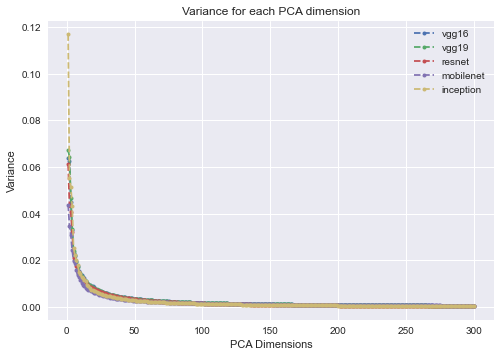

In [15]:
models = ['vgg16','vgg19','resnet','mobilenet','inception']

num_pca_comp = 300
for model_type in models:
    pca = PCA(num_pca_comp)
    pca.fit(feature_list[model_type])
    matplotlib.style.use('seaborn')
    plt.plot(range(1,num_pca_comp+1),pca.explained_variance_ratio_,'o--', markersize=4, label=model_type )
plt.title ('Variance for each PCA dimension')
plt.xlabel('PCA Dimensions')
plt.ylabel('Variance')
plt.legend()
plt.grid(True)
plt.show()

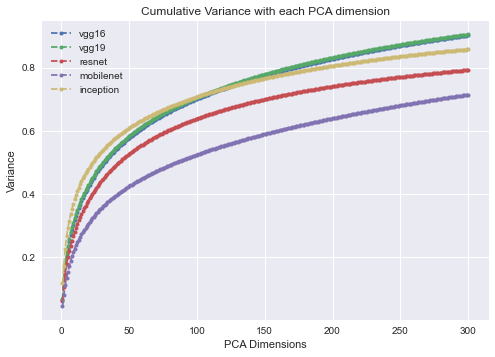

In [16]:
for model_type in models:
    pca = PCA(num_pca_comp)
    pca.fit(feature_list[model_type])
    matplotlib.style.use('seaborn')
    plt.plot(range(1,num_pca_comp+1),pca.explained_variance_ratio_.cumsum(),'o--', markersize=4, label=model_type )
plt.title ('Cumulative Variance with each PCA dimension')
plt.xlabel('PCA Dimensions')
plt.ylabel('Variance')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
pca_dimensions = [1,2,3,4,5,10,20,50,75,100,200,250,300]
pca_accuracy = dict()
pca_time = dict()

for model_type in models:
    pca_accuracy[model_type] = []
    pca_time[model_type] = []
    for dimensions in pca_dimensions:
        pca = PCA(dimensions)
        pca.fit(feature_list[model_type])
        feature_list_compressed = pca.transform(feature_list[model_type][:])
        # Calculate accuracy over the compressed features
        accuracy, time_taken = calculate_accuracy(feature_list_compressed[:])
        pca_time[model_type].append(time_taken)
        pca_accuracy[model_type].append(accuracy)
        print(f"For PCA Dimensions ({model_type})= ", dimensions, ",\tAccuracy = ",accuracy,"%", ",\tTime = ", time_taken)

6294 28414
For PCA Dimensions (vgg16)=  1 ,	Accuracy =  18.13 % ,	Time =  3.2772536277770996
7910 26798
For PCA Dimensions (vgg16)=  2 ,	Accuracy =  22.79 % ,	Time =  5.3249170780181885
11553 23155
For PCA Dimensions (vgg16)=  3 ,	Accuracy =  33.29 % ,	Time =  5.270508050918579
14109 20599
For PCA Dimensions (vgg16)=  4 ,	Accuracy =  40.65 % ,	Time =  5.399146795272827
15519 19189
For PCA Dimensions (vgg16)=  5 ,	Accuracy =  44.71 % ,	Time =  5.285256624221802
21722 12986
For PCA Dimensions (vgg16)=  10 ,	Accuracy =  62.58 % ,	Time =  5.21161961555481
26398 8310
For PCA Dimensions (vgg16)=  20 ,	Accuracy =  76.06 % ,	Time =  5.6826207637786865
28768 5940
For PCA Dimensions (vgg16)=  50 ,	Accuracy =  82.89 % ,	Time =  7.294513702392578
29225 5483
For PCA Dimensions (vgg16)=  75 ,	Accuracy =  84.2 % ,	Time =  9.26527738571167
29427 5281
For PCA Dimensions (vgg16)=  100 ,	Accuracy =  84.78 % ,	Time =  11.989814043045044
29488 5220
For PCA Dimensions (vgg16)=  200 ,	Accuracy =  84.96 % ,	T

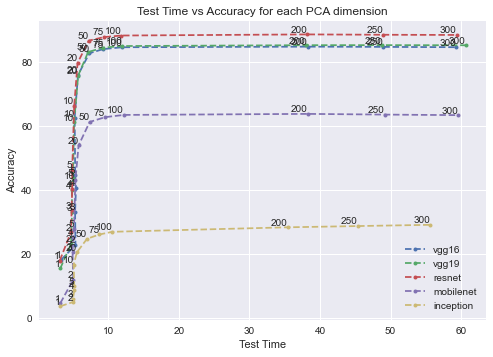

In [18]:
for model_type in models:
    plt.plot(pca_time[model_type], pca_accuracy[model_type],'o--', markersize=4, label=model_type)
    for label, x, y in zip(pca_dimensions, pca_time[model_type], pca_accuracy[model_type]):
        plt.annotate(label, xy=(x, y), ha='right', va='bottom')
plt.title ('Test Time vs Accuracy for each PCA dimension')
plt.xlabel('Test Time')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

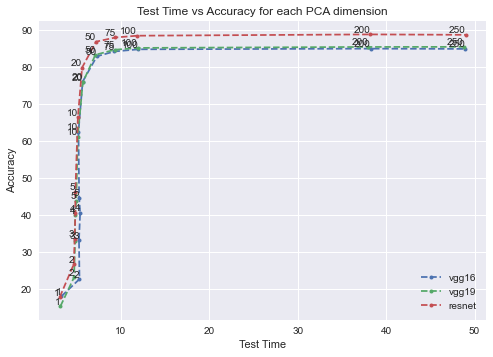

In [19]:

for model_type in ['vgg16','vgg19','resnet']:
    plt.plot(pca_time[model_type][:-1], pca_accuracy[model_type][:-1],'o--', markersize=4, label=model_type)
    for label, x, y in zip(pca_dimensions[:-1], pca_time[model_type][:-1], pca_accuracy[model_type][:-1]):
        plt.annotate(label, xy=(x, y), ha='right', va='bottom')
plt.title ('Test Time vs Accuracy for each PCA dimension')
plt.xlabel('Test Time')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

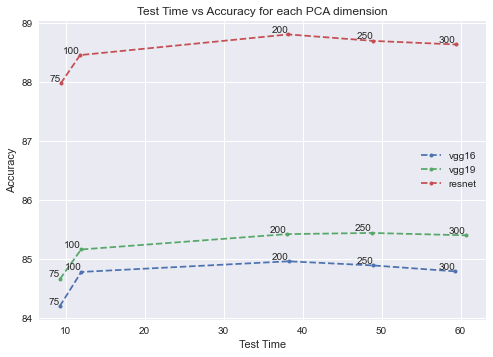

In [20]:

for model_type in ['vgg16','vgg19','resnet']:
    plt.plot(pca_time[model_type][-5:], pca_accuracy[model_type][-5:],'o--', markersize=4, label=model_type)
    for label, x, y in zip(pca_dimensions[-5:], pca_time[model_type][-5:], pca_accuracy[model_type][-5:]):
        plt.annotate(label, xy=(x, y), ha='right', va='bottom')
plt.title ('Test Time vs Accuracy for each PCA dimension')
plt.xlabel('Test Time')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()